In [77]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pynwb import NWBFile, NWBHDF5IO

In [78]:
# Specify data path and filename(s)
data_dir = os.path.join('..','data', 'nwb2.0')
fname = 'mouse1_fni16_150821_001-002_ch2-PnevPanResults-170808-184141.nwb'

In [79]:
# Read NWB 2.0 file
nwb_io = NWBHDF5IO(os.path.join(data_dir, fname), mode = 'r')
nwbfile = nwb_io.read()

In [80]:
# Extract all trial-based ROI time-series
# ROI time-series has the shape of: (ROI count) x (time instances) x (trial count)
roi_series = nwbfile.modules.get('Trial-based').data_interfaces.get('deconvolved dF-over-F').roi_response_series

In [81]:
# Display all event-type data are time locked to
for eve in roi_series.keys():
    print(eve)

commitIncorrAl
firstSideTryAl
firstSideTryAl_COM
goToneAl
initToneAl
rewardAl
stimAl_allTrs
stimAl_noEarlyDec
stimOffAl


In [82]:
# Function to extract trial-based data based on event name, pre/post stimulus duration
def get_trialsegmented_data(event_name, pre_stim_dur, post_stim_dur, roi_series):
    d_obj = roi_series.get(event_name)
    data = np.array(d_obj.data)
    tvec = np.array(d_obj.timestamps)
    # check if pre/post stim duration is out of bound
    pre_stim_dur = tvec[0] if pre_stim_dur < tvec[0] else pre_stim_dur
    post_stim_dur = tvec[-1] if post_stim_dur > tvec[-1] else post_stim_dur    
    # extract data
    data = data[:, ((tvec >= pre_stim_dur) & (tvec <= post_stim_dur)), :]
    timestamps = tvec[((tvec >= pre_stim_dur) & (tvec <= post_stim_dur))]
    return data, timestamps      

In [86]:
# Obtain inh/exc status of the ROI
roi_tcourse = roi_series.get('initToneAl')
good_roi_mask = roi_tcourse.rois.data
roi_table = roi_tcourse.rois.table
neuron_type = roi_table.get('neuron_type').data[good_roi_mask]

### Reproduce Figure 1E

In [ ]:
# specify event of interest to extract trial data 
segmentation_settings = [
    {'event':'initToneAl', 'pre': -10000, 'post': 100},
    {'event':'stimAl_noEarlyDec', 'pre': -100, 'post': 10000},
    {'event':'firstSideTryAl', 'pre': -250, 'post': 250},
    {'event':'rewardAl', 'pre': -250, 'post': 10000}]

# extract trial-based data and average over trial
trial_avg_segments = {}
for setting in segmentation_settings:
    # extract segment
    out = get_trialsegmented_data(setting['event'], setting['pre'], setting['post'], roi_series)
    # average
    trial_avg_segments[setting['event']] = (np.nanmean(out[0], axis=2), out[1])

In [ ]:
# Function to sort the ROI time-series based on the latency of the peak activity
def roi_sort_by_peak_latency(roi_tcourse):
    sorted_roi_idx = np.argsort(np.argmax(roi_tcourse,axis = 1))
    return roi_tcourse[sorted_roi_idx,:].copy(), sorted_roi_idx

In [10]:
# Sort and concatenate trial-based data time-locked to: start tone, stimulus, 1st commit and 2nd commit

# Concatenate and sort
data_all = np.hstack([ trial_avg_segments[key][0] for key in trial_avg_segments.keys()])
data_all, sorted_roi_idx = roi_sort_by_peak_latency(data_all)

# Concatenate all timevec(s) and determine the indices of t = 0
tvec_concat = [trial_avg_segments[key][1] for key in trial_avg_segments.keys()]
xdim_all = [t.size for t in tvec_concat]
xdim_all.insert(0,0)
zeros_all = [np.where(v == 0)[0][0] for v in tvec_concat]

# Extract inh/exc status
is_inh = np.zeros((data_all.shape[0]))
is_inh[neuron_type[sorted_roi_idx]=='inhibitory'] = 1

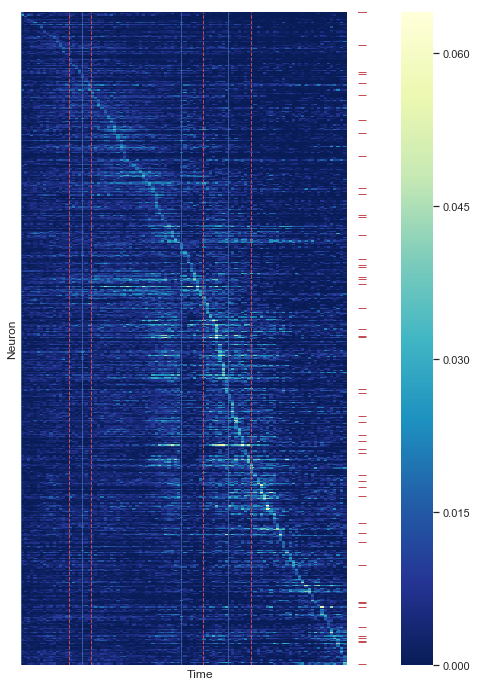

In [53]:
# Raster Plot -  Figure 1E
fig1E = plt.figure(figsize=(8,12))
ax1 = fig1E.add_subplot(111)
ax1.set_facecolor('white')

sns.heatmap(data = data_all,xticklabels = [],yticklabels = [],cmap = 'YlGnBu_r', axes=ax1)

# add vertical lines
for zidx, z in enumerate(zeros_all):
    ax1.axvline(x= np.cumsum(xdim_all)[zidx], color='b',linestyle='-',linewidth=0.7)
    ax1.axvline(x= z + np.cumsum(xdim_all)[zidx], color='r',linestyle='--',linewidth=1)
    
# add inhibitor marker
ax1.plot(np.ones(is_inh.shape)*(data_all.shape[1]+5),np.arange(is_inh.size)*is_inh,'r_',markersize=8)

ax1.set_xlim(0,data_all.shape[1]+10)
ax1.set_xlabel('Time')
ax1.set_ylabel('Neuron')
ax1.set_label('Averaged infered spike for all neurons for an example session')
# fig1.show()

### Reproduce Figure 1F

In [61]:
# Get trial info
trial_set = nwbfile.trials
print(trial_set.colnames)

('start_time', 'stop_time', 'trial_type', 'trial_pulse_rate', 'trial_response', 'trial_is_good', 'init_tone', 'stim_onset', 'stim_offset', 'go_tone', 'first_commit', 'second_commit')


In [62]:
trial_is_good = trial_set.get('trial_is_good').data
trial_response_type = trial_set.get('trial_response').data
trial_type = trial_set.get('trial_type').data

In [70]:
# make trial-mask for correct high-rate (ipsilateral-lick) and low-rate (contralateral-lick) trial
correct_high_rate_trial = (trial_response_type=='correct') & (trial_type=='High-rate')
correct_low_rate_trial = (trial_response_type=='correct') & (trial_type=='Low-rate')

In [91]:
# make mask of inhibitory and excitatory neuron
is_inh = (neuron_type == 'inhibitory')
is_exc = (neuron_type == 'excitatory')

In [97]:
# specify event of interest to extract trial data 
segmentation_settings = [
    {'event':'initToneAl', 'pre': -10000, 'post': 100},
    {'event':'stimAl_noEarlyDec', 'pre': -100, 'post': 10000},
    {'event':'firstSideTryAl', 'pre': -250, 'post': 250},
    {'event':'rewardAl', 'pre': -250, 'post': 10000}]

trial_avg_segments = {}
for setting in segmentation_settings:
    # extract segment
    out = get_trialsegmented_data(setting['event'], setting['pre'], setting['post'], roi_series)
    # mask by high/low rate trial and inh/exc neuron type
    exc_correct_hr = out[0][:,:,correct_high_rate_trial][is_exc,:,:]
    inh_correct_hr = out[0][:,:,correct_high_rate_trial][is_inh,:,:]
    exc_correct_lr = out[0][:,:,correct_low_rate_trial][is_exc,:,:]
    inh_correct_lr = out[0][:,:,correct_low_rate_trial][is_inh,:,:]
    # take average across trials
    trial_avg_segments[setting['event']] = {'exc_correct_hr':np.nanmean(exc_correct_hr, axis=2),
                                            'inh_correct_hr':np.nanmean(inh_correct_hr, axis=2),
                                            'exc_correct_lr':np.nanmean(exc_correct_lr, axis=2),
                                            'inh_correct_lr':np.nanmean(inh_correct_lr, axis=2),
                                            'timestamps':out[1]}

In [194]:
# plot a single subplot of Figure 1F
def plot_sub_fig1F(exc_ax, inh_ax, trial_avg_segments, exc_idx, inh_idx):    
  
    # make a nan-padding between each dataset 
    pad_size = 3
    nan_padding = np.full((pad_size),np.nan)
    
    # Concatenate and add nan padding in between
    exc_correct_hr = []
    inh_correct_hr = []
    exc_correct_lr = []
    inh_correct_lr = []
    tvec = []
    for k in trial_avg_segments.keys():
        exc_correct_hr.append(np.hstack([trial_avg_segments[k]['exc_correct_hr'][exc_idx,:], nan_padding]))
        inh_correct_hr.append(np.hstack([trial_avg_segments[k]['inh_correct_hr'][inh_idx,:], nan_padding]))        
        exc_correct_lr.append(np.hstack([trial_avg_segments[k]['exc_correct_lr'][exc_idx,:], nan_padding]))        
        inh_correct_lr.append(np.hstack([trial_avg_segments[k]['inh_correct_lr'][inh_idx,:], nan_padding]))
        tvec.append(np.hstack([trial_avg_segments[k]['timestamps'], nan_padding]))
        
    exc_correct_hr = np.hstack(exc_correct_hr)
    inh_correct_hr = np.hstack(inh_correct_hr)
    exc_correct_lr = np.hstack(exc_correct_lr)
    inh_correct_lr = np.hstack(inh_correct_lr)
    tvec = np.hstack(tvec)
    
    # determine the indices of t = 0
    t_zeros = np.where(tvec == 0)[0]

    # plot excitatory
    exc_ax.plot(exc_correct_lr, 'k', alpha=0.6) 
    exc_ax.plot(exc_correct_hr, 'g', alpha=0.8)   
    # add vertical lines
    for t in t_zeros:
        exc_ax.axvline(x=t, color='k', linestyle='--', linewidth=0.7)
    exc_ax.set_facecolor('w')
    exc_ax.set_xticklabels([])
    exc_ax.set_title(f'exh: {exc_idx}')

    # plot inhibitory
    inh_ax.plot(inh_correct_lr, 'k', alpha=0.6) 
    inh_ax.plot(inh_correct_hr, 'g', alpha=0.8)  
    # add vertical lines
    for t in t_zeros:
        inh_ax.axvline(x=t, color='k', linestyle='--', linewidth=0.7)      
    inh_ax.set_facecolor('w')
    inh_ax.set_xticklabels([])
    inh_ax.set_title(f'inh: {inh_idx}')

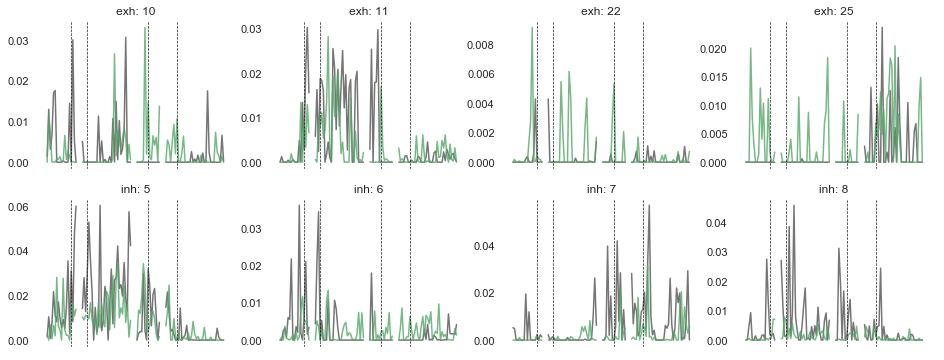

In [195]:
# Plot figure 1F
fig1F = plt.figure(figsize=(16,6))
exc_idx = [10,11,22,25]
inh_idx = [5,6,7,8]
plot_sub_fig1F(fig1F.add_subplot(241), fig1F.add_subplot(245), trial_avg_segments, exc_idx[0], inh_idx[0])
plot_sub_fig1F(fig1F.add_subplot(242), fig1F.add_subplot(246), trial_avg_segments, exc_idx[1], inh_idx[1])
plot_sub_fig1F(fig1F.add_subplot(243), fig1F.add_subplot(247), trial_avg_segments, exc_idx[2], inh_idx[2])
plot_sub_fig1F(fig1F.add_subplot(244), fig1F.add_subplot(248), trial_avg_segments, exc_idx[3], inh_idx[3])

In [13]:
nwb_io.close()